In [1]:
from numpy import dtype
from torch.utils.data import Dataset
%load_ext watermark
%watermark -v -p numpy,pandas,matplotlib,torch

Python implementation: CPython
Python version       : 3.11.6
IPython version      : 9.4.0

numpy     : 1.26.0
pandas    : 2.3.0
matplotlib: 3.10.3
torch     : 2.2.2



In [2]:
import os
import pandas as pd
import numpy as np
from pathlib import Path

NBS_DIR = Path().resolve()
# REPO_DIR = NBS_DIR.parent
REPO_DIR = NBS_DIR
REPO_DIR
DATA_DIR = REPO_DIR / 'assets'
IMDB_DIR = DATA_DIR / 'IMDB'



In [4]:
train_df = pd.read_csv(IMDB_DIR / 'train.csv')
val_df = pd.read_csv(IMDB_DIR / 'val.csv')
test_df = pd.read_csv(IMDB_DIR / 'test.csv')

print(f"Train label count {np.bincount(train_df['label'])}")
print(f"Val label count {np.bincount(val_df['label'])}")
print(f"Test label count {np.bincount(test_df['label'])}")

Train label count [17452 17548]
Val label count [2542 2458]
Test label count [5006 4994]


# Bag-of-words Model

In [17]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer(
    lowercase=True,
    stop_words='english',
    max_features=10_000
)
X_train = count_vect.fit_transform(train_df['text'])
X_val = count_vect.transform(val_df['text'])
X_test = count_vect.transform(test_df['text'])

In [18]:
len(count_vect.vocabulary_)

10000

In [16]:
count_vect.vocabulary_

{'fame': 3370,
 'best': 951,
 'movies': 5922,
 've': 9530,
 'seen': 7900,
 'performing': 6545,
 'arts': 624,
 'music': 5954,
 'acting': 234,
 'excellent': 3219,
 'screenplay': 7845,
 'set': 7969,
 'design': 2515,
 'favorite': 3422,
 'students': 8658,
 'start': 8515,
 'dancing': 2301,
 'making': 5496,
 'movie': 5920,
 'number': 6171,
 'times': 9102,
 'bored': 1109,
 '10': 3,
 'fully': 3735,
 'deserves': 2513,
 'hindi': 4290,
 'comedies': 1830,
 'known': 5051,
 'gritty': 4032,
 'hard': 4146,
 'hitting': 4312,
 'social': 8298,
 'dramas': 2799,
 'easily': 2928,
 'br': 1144,
 'plot': 6693,
 'revolves': 7510,
 'small': 8262,
 'town': 9180,
 'khan': 4989,
 'salman': 7729,
 'want': 9683,
 'rich': 7525,
 'quick': 7084,
 'big': 968,
 'city': 1672,
 'hatch': 4176,
 'plan': 6658,
 'woo': 9891,
 'heiress': 4232,
 'daughter': 2337,
 'businessman': 1290,
 'paresh': 6438,
 'marries': 5563,
 'gets': 3849,
 'hands': 4123,
 'wealth': 9743,
 'know': 5048,
 'intense': 4697,
 'hilarious': 4283,
 'gags': 376

In [19]:
X_train.shape

(35000, 10000)

In [25]:
feat_vec = np.array(X_train[0].todense())[0]
feat_vec.shape

(10000,)

In [36]:
np.bincount(feat_vec), train_df.columns

(array([9977,   21,    2]), Index(['index', 'text', 'label'], dtype='object'))

# 3_ Defining the dataloader

In [96]:
from torch.utils.data import DataLoader, Dataset
import torch

class TextDataset(Dataset):
    def __init__(self,features,labels):
        self.features = torch.tensor(features,dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.int64)

    def __getitem__(self, index):
        x = self.features[index]
        y = self.labels[index]
        return x,y

    def __len__(self):
        return self.labels.shape[0]



In [97]:
train_ds = TextDataset(X_train.todense(), train_df['label'].values)
train_loader = DataLoader(
    train_ds,
    shuffle=True,
    batch_size=32,
    drop_last=True,
    num_workers=0
)

val_ds = TextDataset(X_val.todense(), val_df['label'].values)
val_loader = DataLoader(
    val_ds,
    shuffle=False,
    batch_size=32,
    num_workers=0
)

test_ds = TextDataset(X_test.todense(), test_df['label'].values)
test_loader = DataLoader(
    test_ds,
    shuffle=False,
    batch_size=32,
    num_workers=0
)



In [90]:
n_epoch = 1

for batch_idx, (x,y) in enumerate(train_loader):
    break

In [91]:
x.shape

torch.Size([32, 10000])

# implementing a clasifier

In [79]:
import lightning as L
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.callbacks import ModelCheckpoint

In [92]:
from local_utilities import LightningModel
class LogisticRegression(torch.nn.Module):

    def __init__(self, num_features, num_classes):
        super().__init__()
        self.linear = torch.nn.Linear(num_features, num_classes)

    def forward(self, x):
        logits = self.linear(x)
        return logits


pytorch_model = LogisticRegression(num_features=10_000, num_classes=2)

call_backs = [
    ModelCheckpoint(save_top_k=1, mode="max",monitor="val_acc", save_last=True)
]

In [93]:
lightning_model = LightningModel(model=pytorch_model, learning_rate=0.05)

In [94]:
trainer = L.Trainer(
    callbacks=call_backs,
    max_epochs=30,
    accelerator='cpu',
    logger=CSVLogger(save_dir="logs/", name='my-model'),
    deterministic=True
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [98]:
trainer.fit(
    model = lightning_model,
    train_dataloaders=train_loader,
    val_dataloaders=val_loader,

)


  | Name      | Type               | Params | Mode
--------------------------------------------------------
0 | model     | LogisticRegression | 20.0 K | eval
1 | train_acc | MulticlassAccuracy | 0      | eval
2 | val_acc   | MulticlassAccuracy | 0      | eval
3 | test_acc  | MulticlassAccuracy | 0      | eval
--------------------------------------------------------
20.0 K    Trainable params
0         Non-trainable params
20.0 K    Total params
0.080     Total estimated model params size (MB)
0         Modules in train mode
5         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/slackroo/Data_science/Deeplearning/seb_pytorch/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Users/slackroo/Data_science/Deeplearning/seb_pytorch/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


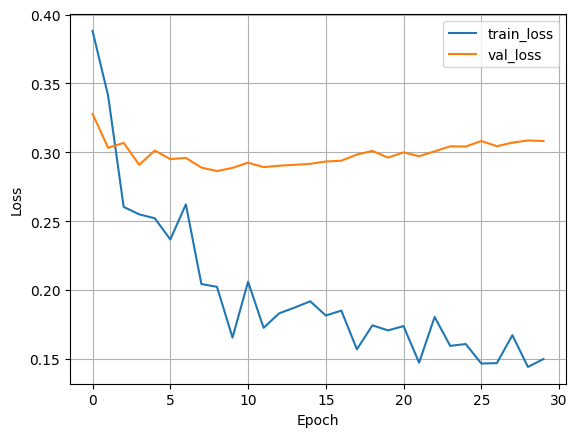

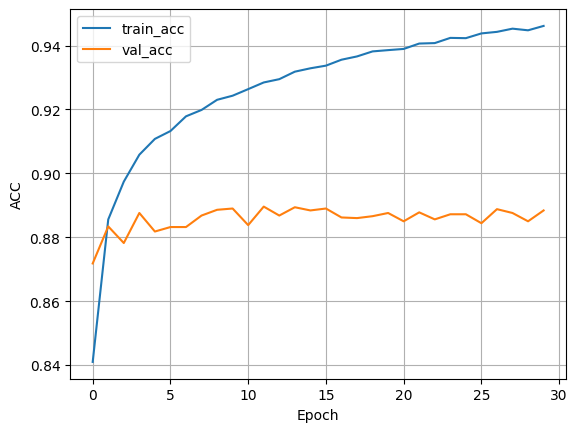

In [99]:

from local_utilities import plot_csv_logger

plot_csv_logger(csv_path=f"{trainer.logger.log_dir}/metrics.csv")

In [100]:
trainer.test(model=lightning_model, dataloaders=test_loader)

/Users/slackroo/Data_science/Deeplearning/seb_pytorch/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.8792999982833862
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc': 0.8792999982833862}]